# Importance sampling using our compiler and BN translator 

This Jupyter's notebook shows importance sampling using our own made compiler and BN translator. 

## Architecture explanation
### From FOPPL to Bayesian Network
We implemented a parser that is able to parse FOPPLs (based on Lisp) to an AST, this AST is then translated to a Bayesian Network representation using a translator. To explain more clear:
1. The FOPPL to AST parser is located in the foppl_parser.py file, FOPPL is tokenized using the FOPPLLexer class, these tokens are then parsed into an AST using the FOPPLParser class. The AST nodes representations can be found in the ast_class.py file
2. The AST is then translated to a Bayesian Network representation (in a Python dictionary) by our Translator class found in the translator.py file

### Importance Sampling

To execute importance sampling we need to be able to sample from our Bayesian Network graph, we this as follows:
1. In the importance_samplin.py file we have a ImportanceSampler class that is able to sample from a Bayesian Network presentation (in our case BN inside a Python dict)
2. We draw multiple samples using the sampler class (which assigns a weight to each sample x)
3. Normalize by applying the total weights to each sampled x and compute the posterior mean of x

### Imports

In [2]:
from ast_nodes import If, Constant, Sample, Let, Observe, Variable, Assign, For
from translator import Translator
from importance_sampling import ImportanceSampler
import math
from foppl_parser import FOPPLLexer, FOPPLParser

In [4]:
# Test Importance Sampling

# # 1) Define a simple AST:
# simple_ast = [
#         Sample("x", ("normal", 0.0, 1.0)),
#         Observe(("normal", Variable("x"), 2.0), 0.5)
#     ]

# A simple FOPPL program (Lisp-style syntax)
simple_foppl = """
(sample x (normal 0.0 1.0))
(observe (normal x 2.0) 0.5)
"""

# Step 1: Lexical analysis (tokenization)
lexer = FOPPLLexer(simple_foppl)

# Step 2: Parsing the tokens into an AST
parser = FOPPLParser(lexer)
simple_ast = parser.parse()

# 2) Translate AST -> Graph
translator = Translator()
graph = translator.translate_program(simple_ast)

# 3) Instantiate ImportanceSampler
sampler = ImportanceSampler(graph)

# 4) Draw multiple samples
N = 5000
samples = []
weights = []
for _ in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # store weight in linear scale

# 5) Analyze results: e.g. compute weighted mean of x
weighted_sum = 0.0
total_weight = 0.0
for env, w in zip(samples, weights):
    weighted_sum += env["x"] * w
    total_weight += w
posterior_mean_x = weighted_sum / total_weight

print(f"Approx. posterior mean of x = {posterior_mean_x:.3f}")

TypeError: unsupported operand type(s) for -: 'Constant' and 'float'

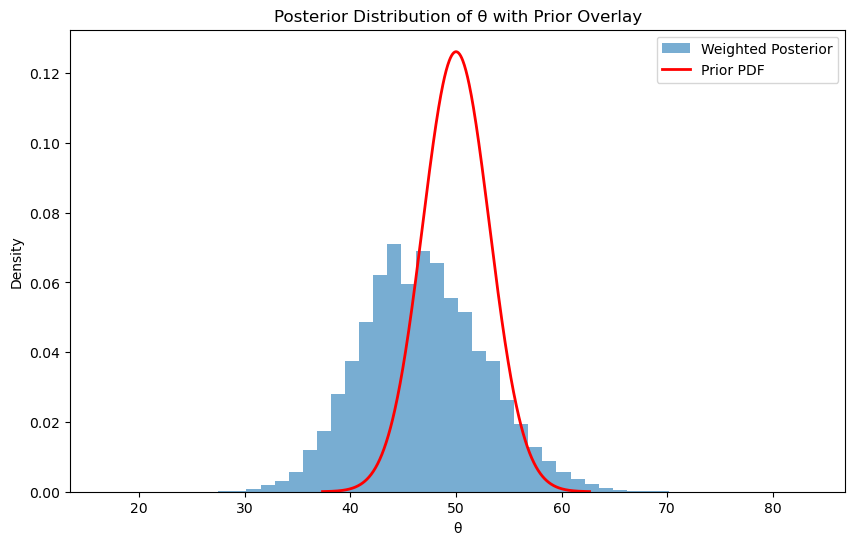

Approx. posterior mean of theta = 46.907


In [ ]:
# Importance Sampling for model 1.2
from ast_nodes import Sample, Observe, Variable
from translator import Translator
from importance_sampling import ImportanceSampler
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # for the Normal PDF



mu0 = 50        # example prior mean
tau2 = 10.0       # example prior variance
y_obs = 45   # observed count


"""
(let [theta (sample (normal mu0 tau2))]
  (observe (poisson theta) y_obs)
  theta)
"""

program_ast = [
    Sample("theta", ("normal", mu0, tau2)),
    Observe(("poisson", Variable("theta")), y_obs)
]

translator = Translator()
graph = translator.translate_program(program_ast)
sampler = ImportanceSampler(graph)

N = 5000
samples = []
weights = []
for i in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # convert log weight to linear scale

weighted_sum = 0.0
total_weight = 0.0

for env, w in zip(samples, weights):
    weighted_sum += env["theta"] * w
    total_weight += w
posterior_mean_theta = weighted_sum / total_weight

theta_vals = np.array([env["theta"] for env in samples])
weights_array = np.array(weights)

plt.figure(figsize=(10, 6))

# Plot the weighted histogram of posterior samples
counts, bins, _ = plt.hist(theta_vals, bins=50, density=True, weights=weights_array,
                         alpha=0.6, label='Weighted Posterior')

sigma0 = math.sqrt(tau2)

# Create a range of theta values for plotting the prior PDF
theta_range = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 500)

# Compute the prior PDF for these theta values
prior_pdf = stats.norm.pdf(theta_range, loc=mu0, scale=sigma0)

# Plot the prior PDF
plt.plot(theta_range, prior_pdf, 'r-', lw=2, label='Prior PDF')

plt.xlabel('θ')
plt.ylabel('Density')
plt.title('Posterior Distribution of θ with Prior Overlay')
plt.legend()
plt.show()

print(f"Approx. posterior mean of theta = {posterior_mean_theta:.3f}")